In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Make a [tonic](https://tonic.readthedocs.io/en/latest/) dataset - see [documentation](https://tonic.readthedocs.io/en/latest/tutorials/wrapping_own_data.html)
# ## Example with the RGB frames dataset provided by NTUA, translated by UCA into events using vid2e

from dataset_creation_aprovis3d import aprovis3dDataset
from os import walk, path
import numpy as np
import matplotlib.pyplot as plt

# path where you'll go to find your .npy files to make the dataset with
### TO BE MODIFIED
# path = '../../Data/DVS128_ZED_NUC_jAER/'
data_path = '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/'

/home/amelie/VirtualEnvironments/HOTS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
event_files = []
for (rep_path, _, files) in walk(data_path):
    for f in files: 
        if f.endswith('.npy') and not f.endswith('cut.npy') and 'zed' not in f:
            event_files.append(path.join(rep_path, f))
print(event_files)

['/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_5_only_ground/DVS128_06_06_2022_session_5.npy', '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_4_only_sea/DVS128_06_06_2022_session_4.npy', '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_3_only_ground/DVS128_06_06_2022_session_3.npy', '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_6_only_sea/DVS128_06_06_2022_session_6.npy', '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_2_only_sea/DVS128_06_06_2022_session_2.npy', '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_1_only_ground/DVS128_06_06_2022_session_1.npy']


In [3]:
# load data
ev = {'session '+file_ev[-5]: np.load(file_ev) for file_ev in event_files}
label = {'session '+file_ev[-5]: 'sea' if 'sea' in file_ev else 'ground' for file_ev in event_files}
print(ev.keys())
print(label)

dtype = np.dtype([("x", int), ("y", int), ("t", int), ("p", int)])
ordering = dtype.names

dict_keys(['session 5', 'session 4', 'session 3', 'session 6', 'session 2', 'session 1'])
{'session 5': 'ground', 'session 4': 'sea', 'session 3': 'ground', 'session 6': 'sea', 'session 2': 'sea', 'session 1': 'ground'}


# Display event repartition

In [4]:
min_ts = {}
max_ts = {}
for ev_session, ev_data in ev.items():
    min_ts[ev_session] = np.min(ev_data[:,ordering.index('t')])
    max_ts[ev_session] = np.max(ev_data[:,ordering.index('t')])
    print('>',ev_session)
    print('Min timestamps:', min_ts[ev_session])
    print('Max timestamps:', max_ts[ev_session])

> session 5
Min timestamps: 0
Max timestamps: 392226858
> session 4
Min timestamps: 0
Max timestamps: 250666280
> session 3
Min timestamps: 0
Max timestamps: 249250294
> session 6
Min timestamps: 0
Max timestamps: 106799566
> session 2
Min timestamps: 0
Max timestamps: 182615916
> session 1
Min timestamps: 0
Max timestamps: 287532613


# Events repartition across time
The samples are temporally split into successive patches, each $1s$ long.

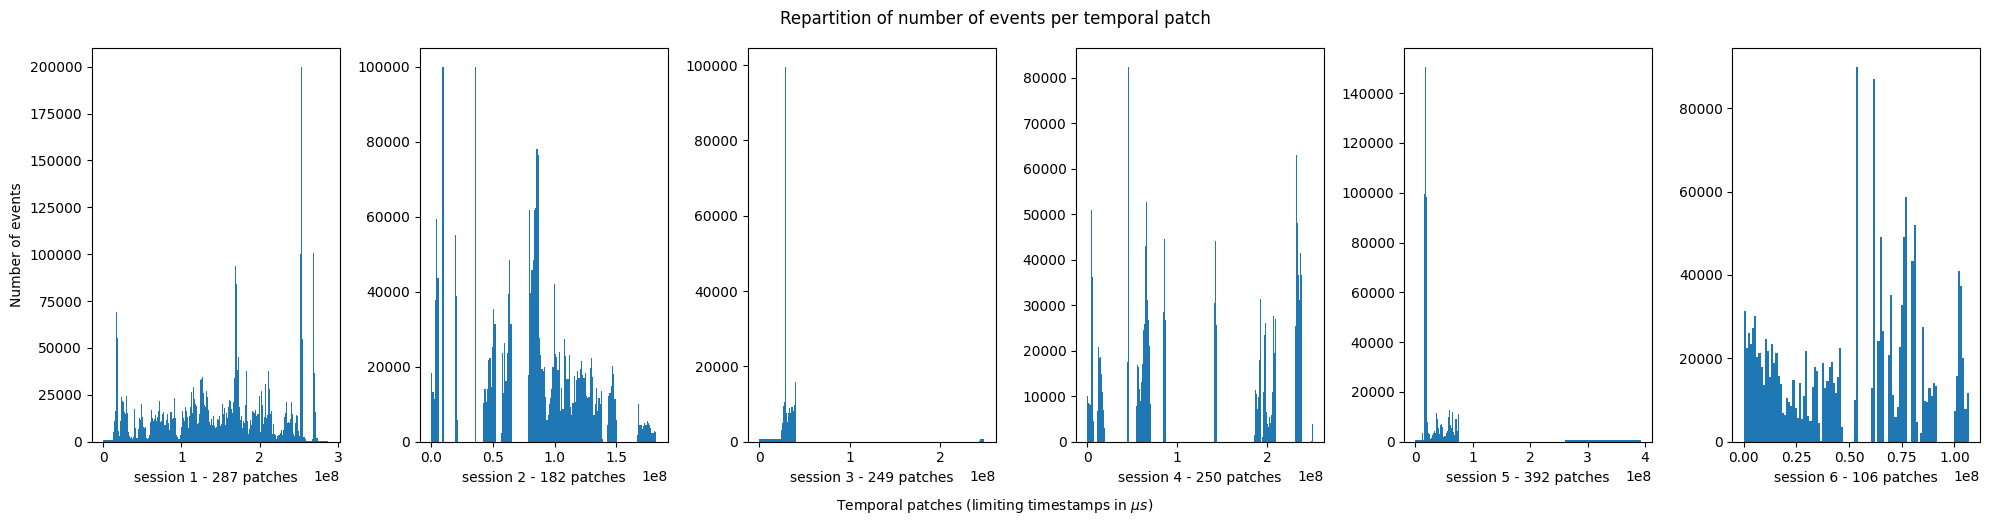

In [5]:
fig, ax = plt.subplots(1,len(ev.keys()),figsize=(20,5))
ax[0].set_ylabel('Number of events')
for ev_session, ev_data in ev.items():
    frame_bin=int(max(ev_data[:,ordering.index('t')])/1e6)
    idx = int(ev_session[-1])-1
    ax[idx].set_xlabel(ev_session + ' - ' + str(frame_bin)+' patches')
    ax[idx].hist(ev_data[:, ordering.index('t')], bins=frame_bin)
fig.suptitle('Repartition of number of events per temporal patch')
fig.text(0.5, -0.02, r'Temporal patches (limiting timestamps in $\mu s$)', ha='center')
fig.tight_layout()

In [6]:
nb_events_per_bin = {}
for ev_session, ev_data in ev.items():
    nb_events_per_bin[ev_session] = np.histogram(
        ev_data[:, ordering.index("t")],
        bins = range(int(min_ts[ev_session]), int(max_ts[ev_session])+1, int(1e6))
    )[0]
    
    print('>', ev_session)
    print('Number of bins:',len(nb_events_per_bin[ev_session]))
    print('Empty bins in patches of 1s:', list(nb_events_per_bin[ev_session]).count(0))
    print('Max nb of events per bin:',max(nb_events_per_bin[ev_session]))

> session 5
Number of bins: 392
Empty bins in patches of 1s: 185
Max nb of events per bin: 144964
> session 4
Number of bins: 250
Empty bins in patches of 1s: 176
Max nb of events per bin: 93567
> session 3
Number of bins: 249
Empty bins in patches of 1s: 203
Max nb of events per bin: 99512
> session 6
Number of bins: 106
Empty bins in patches of 1s: 25
Max nb of events per bin: 91589
> session 2
Number of bins: 182
Empty bins in patches of 1s: 67
Max nb of events per bin: 100000
> session 1
Number of bins: 287
Empty bins in patches of 1s: 1
Max nb of events per bin: 165071


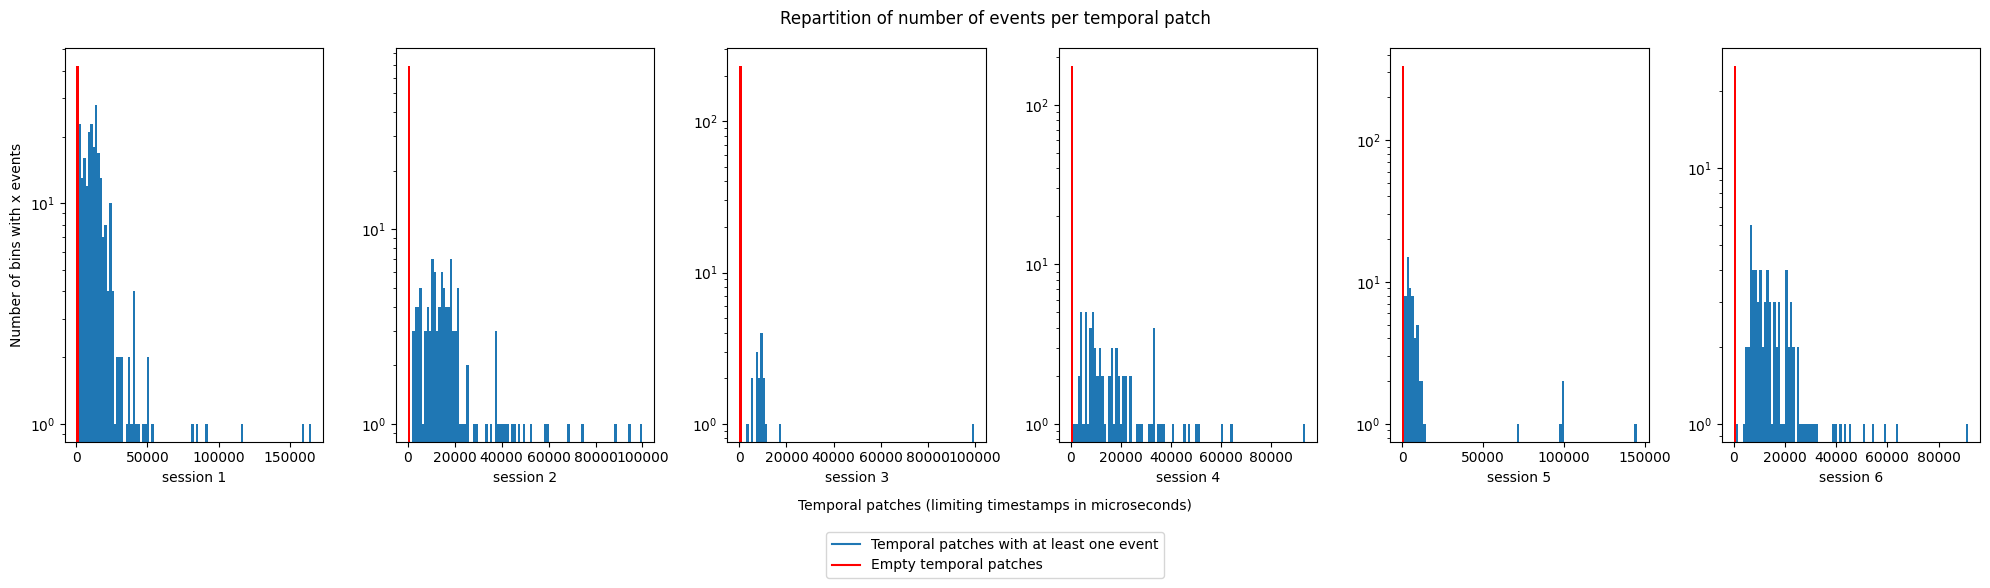

In [7]:
fig, ax = plt.subplots(1,len(ev.keys()),figsize=(20,5))
ax[0].set_ylabel('Number of bins with x events')

for ev_session, ev_data in ev.items():
    idx = int(ev_session[-1])-1
    ax[idx].set_yscale('log')
    ax[idx].set_xlabel(ev_session)

    _, _, patches = ax[idx].hist(nb_events_per_bin[ev_session], bins=100)
    patches[0].set_fc('r')

plt.plot([], color='C0',label='Temporal patches with at least one event')
plt.plot([], color='red', label='Empty temporal patches')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.suptitle('Repartition of number of events per temporal patch')
fig.text(0.5, -0.02, 'Temporal patches (limiting timestamps in microseconds)', ha='center')
fig.tight_layout()

# Visualise frame

In [8]:
# timewindow = bin_frame
W = H = []

positive_ev = {}
negative_ev = {}

for ev_session, ev_data in ev.items():
    positive_ev[ev_session] = ev_data[ ev_data[:,ordering.index('p')] > 0 ]
    negative_ev[ev_session] = ev_data[ ev_data[:,ordering.index('p')] < 1 ]
    W.append(np.max(ev_data[:,ordering.index('x')]))
    H.append(np.max(ev_data[:,ordering.index('y')]))
W = max(W)
H = max(H)
print('sensor size:',W,H)

sensor size: 127 127


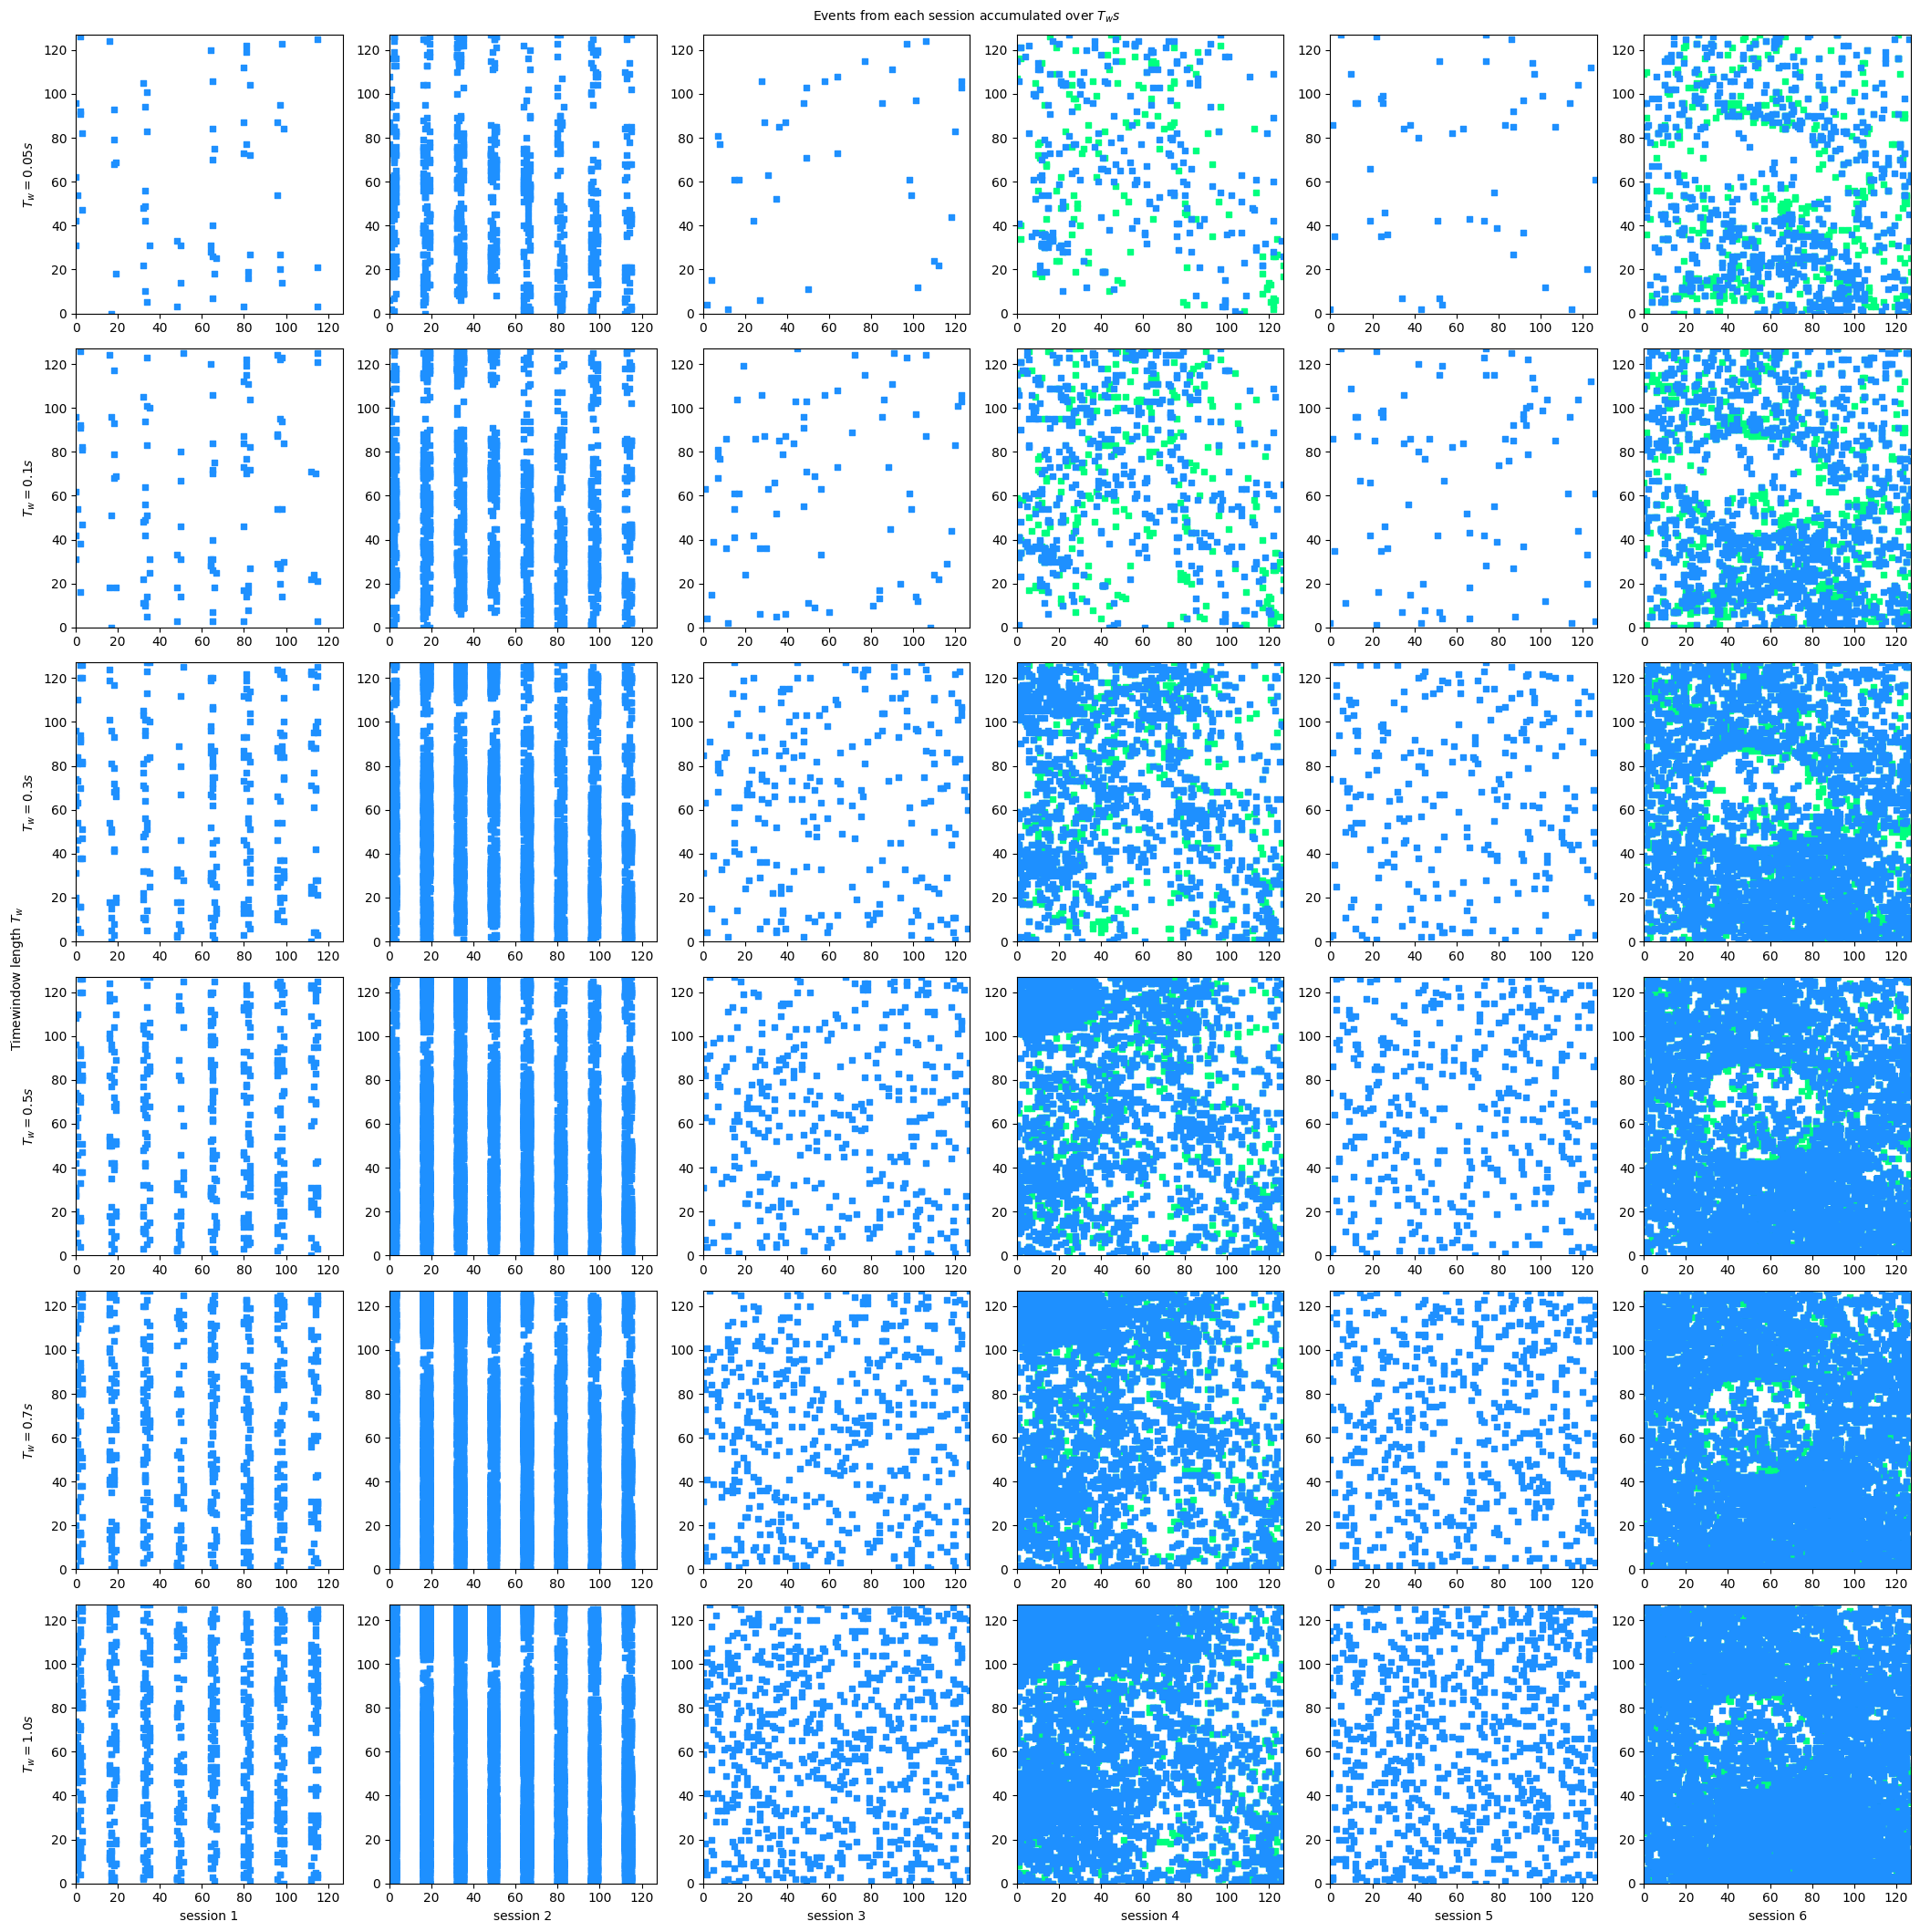

In [9]:
timewindow = [0.05,0.1,0.3,0.5,0.7,1]
timewindow = list(map(lambda x: 1e6*x, timewindow))

fig_events, ax = plt.subplots(len(timewindow),len(ev.keys()),figsize=(3*(len(ev.keys())+1),int(H*3/W)*(len(timewindow)+1)))
s = fig_events.get_size_inches()[0]  * fig_events.dpi / W

t = 0
for tw in timewindow:
     for ev_session, ev_data in ev.items():
          idx = int(ev_session[-1])-1
          ax[t][idx].set_xlim(0, W)
          ax[t][idx].set_ylim(0,H)

          positive_ev_in_tw = positive_ev[ev_session][positive_ev[ev_session][:,ordering.index('t')] < tw]
          negative_ev_in_tw = negative_ev[ev_session][negative_ev[ev_session][:,ordering.index('t')] < tw]
          scatter_pos_events = ax[t][idx].scatter(positive_ev_in_tw[:,ordering.index('x')], positive_ev_in_tw[:,ordering.index('y')], marker="s", color="springgreen", label="Positive events", s=s)
          scatter_neg_events = ax[t][idx].scatter(negative_ev_in_tw[:,ordering.index('x')], negative_ev_in_tw[:,ordering.index('y')], marker="s", color="dodgerblue", label="Negative events", s=s)
          
          if t == len(timewindow) - 1:
               ax[t][idx].set_xlabel(ev_session)
     
     ax[t][0].set_ylabel(r'$T_w = %s s$' %str(tw/1e6))
     t += 1

fig_events.text(0., 0.5, r'Timewindow length $T_w$',  va='center', rotation='vertical')
fig_events.text(0.5,1.,r'Events from each session accumulated over $T_w s$', ha='center')
fig_events.tight_layout()

## Visualise events with $y=0$ over time

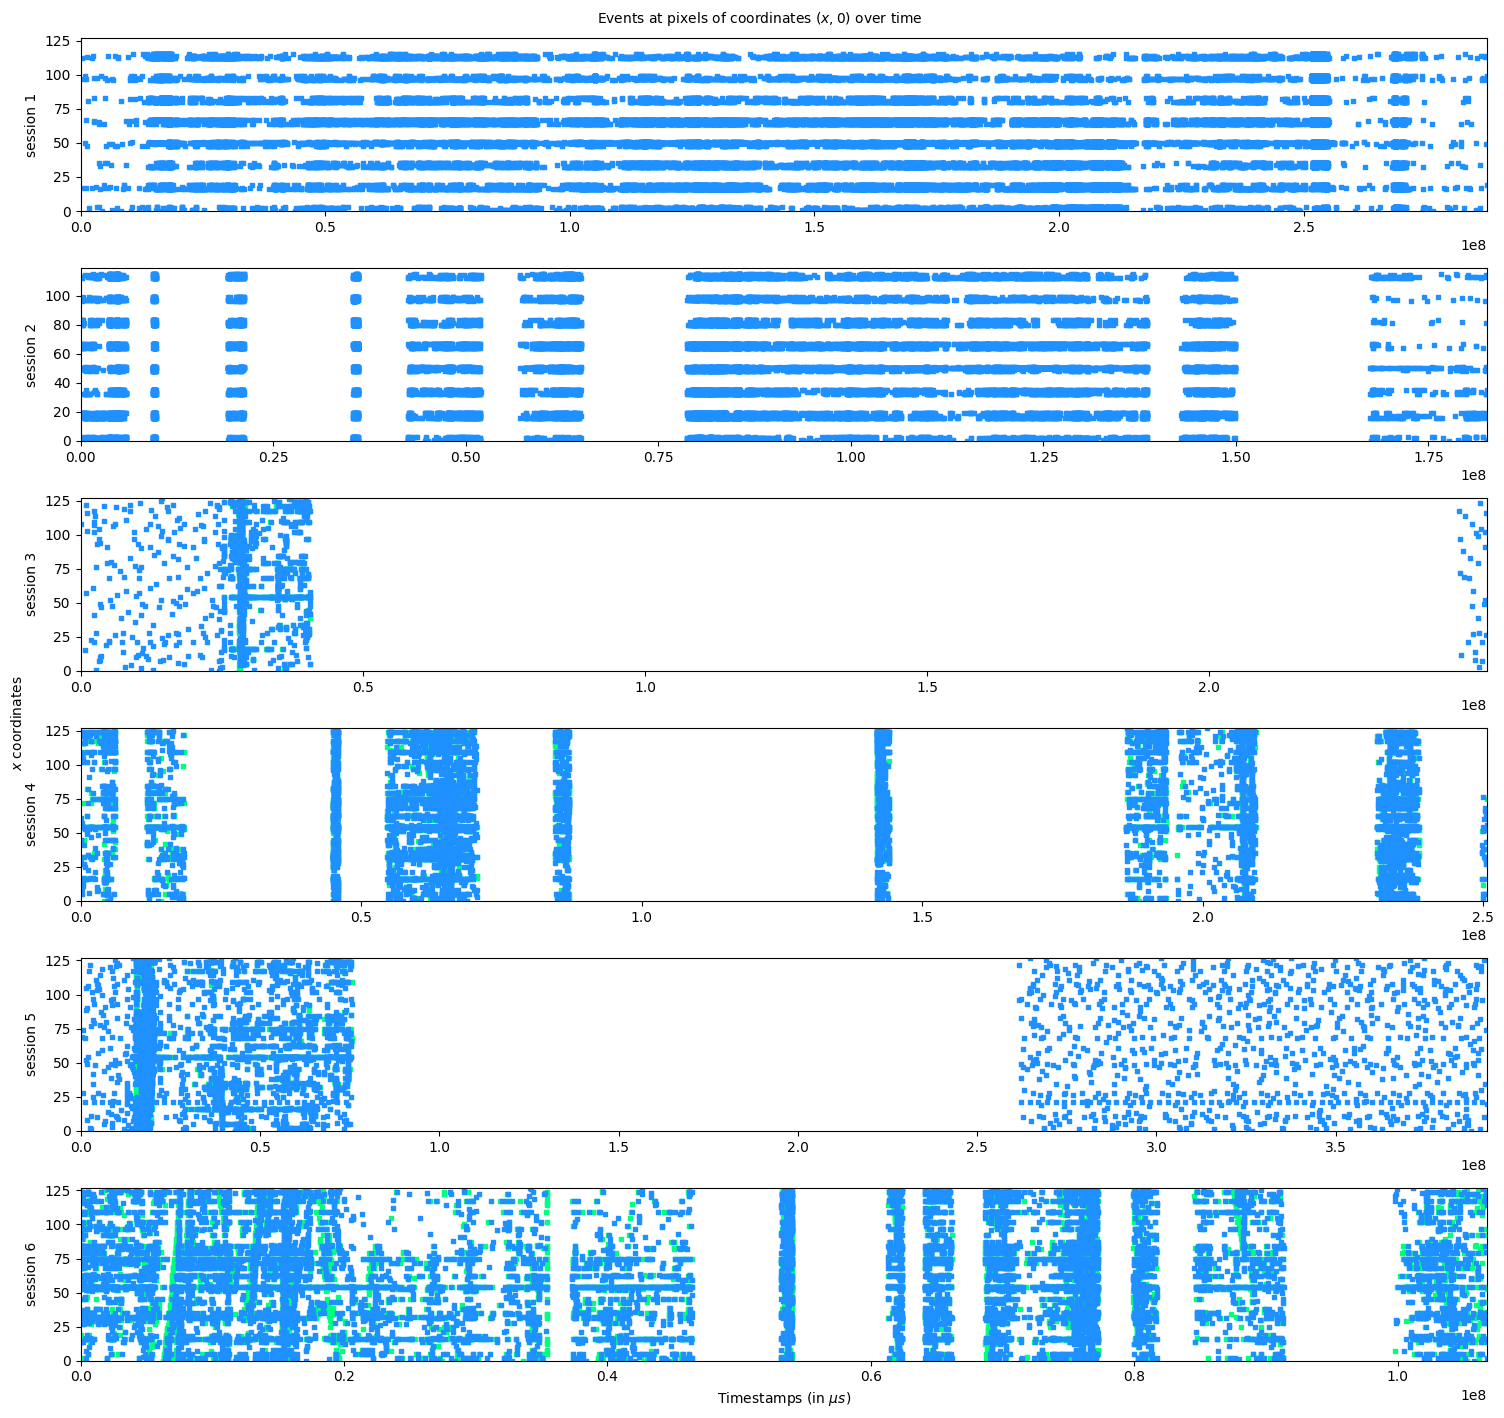

In [10]:
fig_events, ax = plt.subplots(len(ev.keys()),1,figsize=(15,2*(len(ev.keys())+1)))
s = fig_events.get_size_inches()[0]  * fig_events.dpi / W
for ev_session, ev_data in ev.items(): 
    idx = int(ev_session[-1])-1

    ax[idx].set_xlim(0, max_ts[ev_session])
    ax[idx].set_ylim(0,max(ev_data[:,ordering.index('x')]))

    positive_ev = ev_data[ (ev_data[:,ordering.index('p')] > 0) & (ev_data[:,ordering.index('y')] == 0) ]
    negative_ev = ev_data[ (ev_data[:,ordering.index('p')] < 1) & (ev_data[:,ordering.index('y')] == 0) ]

    scatter_pos_events = ax[idx].scatter(positive_ev[:,ordering.index('t')], positive_ev[:,ordering.index('x')], marker="s", color="springgreen", label="Positive events", s=s)
    scatter_neg_events = ax[idx].scatter(negative_ev[:,ordering.index('t')], negative_ev[:,ordering.index('x')], marker="s", color="dodgerblue", label="Negative events", s=s)

    ax[idx].set_ylabel(ev_session)

fig_events.text(0., 0.5, r'$x$ coordinates', va='center', rotation='vertical')
fig_events.text(0.5, 1., r'Events at pixels of coordinates $(x,0)$ over time', ha='center')
ax[-1].set_xlabel(r'Timestamps (in $\mu s$)')
fig_events.tight_layout()

## Visualise events with $x=0$ over time

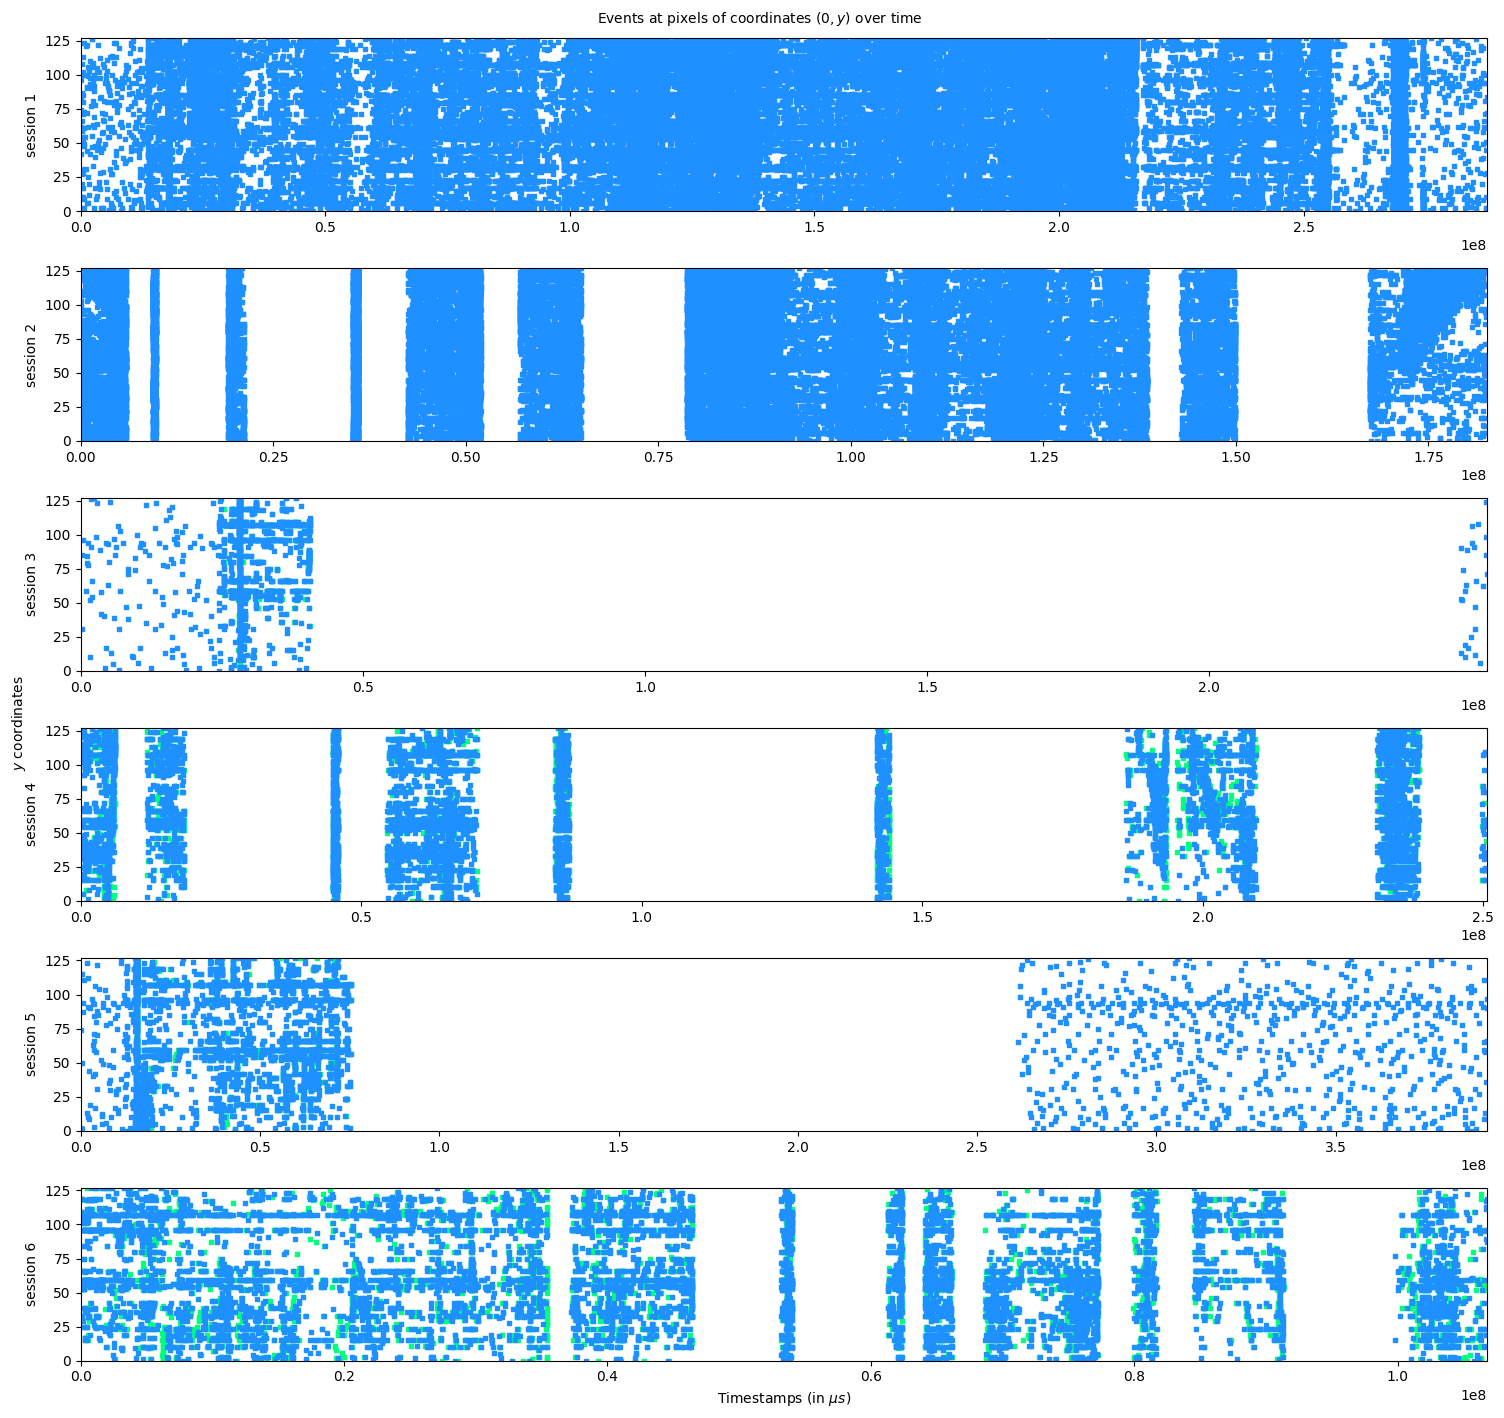

In [11]:
fig_events, ax = plt.subplots(len(ev.keys()),1,figsize=(15,2*(len(ev.keys())+1)))
s = fig_events.get_size_inches()[0]  * fig_events.dpi / W
for ev_session, ev_data in ev.items(): 
    idx = int(ev_session[-1])-1

    ax[idx].set_xlim(0, max_ts[ev_session])
    ax[idx].set_ylim(0,max(ev_data[:,ordering.index('y')]))

    positive_ev = ev_data[ (ev_data[:,ordering.index('p')] > 0) & (ev_data[:,ordering.index('x')] == 0) ]
    negative_ev = ev_data[ (ev_data[:,ordering.index('p')] < 1) & (ev_data[:,ordering.index('x')] == 0) ]

    scatter_pos_events = ax[idx].scatter(positive_ev[:,ordering.index('t')], positive_ev[:,ordering.index('y')], marker="s", color="springgreen", label="Positive events", s=s)
    scatter_neg_events = ax[idx].scatter(negative_ev[:,ordering.index('t')], negative_ev[:,ordering.index('y')], marker="s", color="dodgerblue", label="Negative events", s=s)

    ax[idx].set_ylabel(ev_session)

fig_events.text(0., 0.5, r'$y$ coordinates', va='center', rotation='vertical')
fig_events.text(0.5, 1., r'Events at pixels of coordinates $(0,y)$ over time', ha='center')
ax[-1].set_xlabel(r'Timestamps (in $\mu s$)')
fig_events.tight_layout()

# Visualize event repartition on $x$ and $y$ coordinates

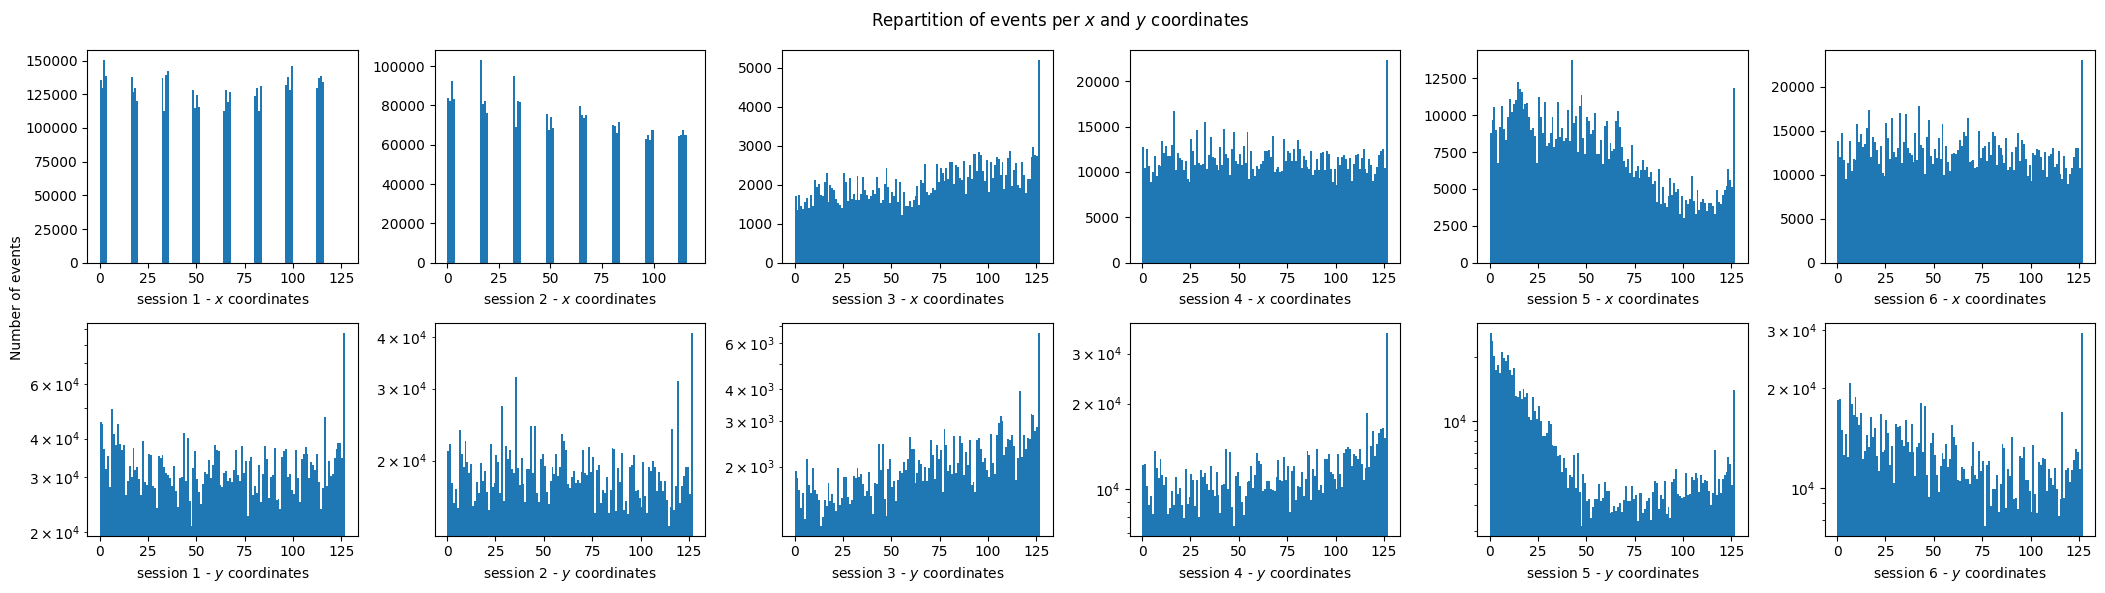

In [14]:
frame_bin=int(1e5)

fig_events, axes = plt.subplots(2,len(ev.keys()),figsize=(3*(len(ev.keys())+1),6))
fig_events.suptitle(r'Repartition of events per $x$ and $y$ coordinates')
s = fig_events.get_size_inches()[0]  * fig_events.dpi / W
for ev_session, ev_data in ev.items(): 
    idx = int(ev_session[-1])-1


    axes[0][idx].hist(ev_data[:, ordering.index('x')], bins=int(max(ev_data[:,ordering.index('x')])))

    axes[1][idx].hist(ev_data[:, ordering.index('y')], bins=int(max(ev_data[:,ordering.index('y')])))
    axes[1][idx].set_yscale('log')
    
    axes[0][idx].set_xlabel(ev_session+r' - $x$ coordinates')
    axes[1][idx].set_xlabel(ev_session+r' - $y$ coordinates')

fig_events.text(0., 0.5, r'Number of events', va='center', rotation='vertical')
fig_events.tight_layout()

The figure above confirms the abnormal repartition of events into specific $x$ coordinates for sessions 1 and 2. We are thus going to discard those two recordings.

# Get dataset information
Adaptation of ```get_dataset_info()``` from ```hots.utils```

In [15]:
def get_properties(events, target, ind_sample, values, ordering = 'xytp', distinguish_polarities = False):
    t_index, p_index = ordering.index('t'), ordering.index('p')
    if distinguish_polarities: 
        for polarity in [0,1]:
            events_pol = events[(events[:, p_index]==polarity)]
            isi = np.diff(events_pol[:, t_index])
            if 'mean_isi' in values.keys():
                values['mean_isi'][polarity, ind_sample, target] = (isi[isi>0]).mean()
            if 'median_isi' in values.keys():
                values['median_isi'][polarity, ind_sample, target] = np.median((isi[isi>0]))
            if 'synchronous_events' in values.keys():
                values['synchronous_events'][polarity, ind_sample, target] = (isi==0).mean()
            if 'nb_events' in values.keys():
                values['nb_events'][polarity, ind_sample, target] = events_pol.shape[0]
    else:
        events_pol = events
        isi = np.diff(events_pol[:, t_index])
        if 'mean_isi' in values.keys():
            values['mean_isi'][0, ind_sample, target] = (isi[isi>0]).mean()
        if 'median_isi' in values.keys():
            values['median_isi'][0, ind_sample, target] = np.median((isi[isi>0]))
        if 'synchronous_events' in values.keys():
            values['synchronous_events'][0, ind_sample, target] = (isi==0).mean()
        if 'nb_events' in values.keys():
            values['nb_events'][0, ind_sample, target] = events_pol.shape[0]
    if 'time' in values.keys():
        values['time'][0, ind_sample, target] = events[-1,t_index]-events[0,t_index]
    return values

def get_dataset_info(ev_data, properties = ['mean_isi', 'synchronous_events', 'nb_events'], distinguish_labels = False, distinguish_polarities = False):
    
    #x_index, y_index, t_index, p_index = trainset.ordering.index("x"), trainset.ordering.index("y"), trainset.ordering.index("t"), trainset.ordering.index("p")
    labelz = ['sea','ground']
    nb_class = len(labelz)
    nb_sample = len(ev_data.keys())
    nb_pola = 2
    
    values = {}
    for name in properties:
        values.update({name:np.zeros([nb_pola, nb_sample, nb_class])})

    idx_sample = 0
    num_labels = np.zeros([nb_class])
    
    for session, events in ev_data.items():
        target = labelz.index(label[session])
        values = get_properties(events, target, idx_sample, values, ordering = ordering, distinguish_polarities = distinguish_polarities)
        num_labels[target] += 1
        idx_sample += 1
        
    print(f'number of samples in each class: {num_labels}')
    print(40*'-')
        
    width_fig = 30
    fig, axs = plt.subplots(1,len(values.keys()), figsize=(width_fig,width_fig//len(values.keys())))
    for i, value in enumerate(values.keys()):
        if distinguish_polarities:
            x = []
            for p in range(nb_pola):
                x.append(values[value][p,:,:].sum(axis=1).ravel())
            ttl = value
        elif distinguish_labels:
            x = []
            for c in range(2): #nb_class):
                x.append(values[value][0,np.nonzero(values[value][0,:,c]),c].ravel())
            ttl = value
        else:
            x = []
            x.append(values[value][0,:,:].sum(axis=1).ravel())
            ttl = value

        for k in range(len(x)):
            n, bins, patches = axs[i].hist(x=x[k], bins='auto',
                                    alpha=.5, rwidth=0.85)
            
        axs[i].grid(axis='y', alpha=0.75)
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Histogram for the {ttl}')
        maxfreq = n.max()
        axs[i].set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
        if not distinguish_labels:
           print(f'Mean value for {ttl}: {np.array(x).mean()}')
        #axs[i].set_xscale("log")
        #axs[i].set_yscale("log")
    return values

number of samples in each class: [3. 3.]
----------------------------------------


{'mean_isi': array([[[   0.        ,  474.48155733],
         [ 177.54292024,    0.        ],
         [   0.        , 1108.56246859],
         [  68.60198227,    0.        ],
         [  79.28112957,    0.        ],
         [   0.        ,   75.21811774]],
 
        [[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ]]]),
 'synchronous_events': array([[[0.        , 0.12253232],
         [0.03097542, 0.        ],
         [0.        , 0.13989465],
         [0.034463  , 0.        ],
         [0.03956894, 0.        ],
         [0.        , 0.07851268]],
 
        [[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]]]),
 'nb_events': array([[[      0.,  942079.]

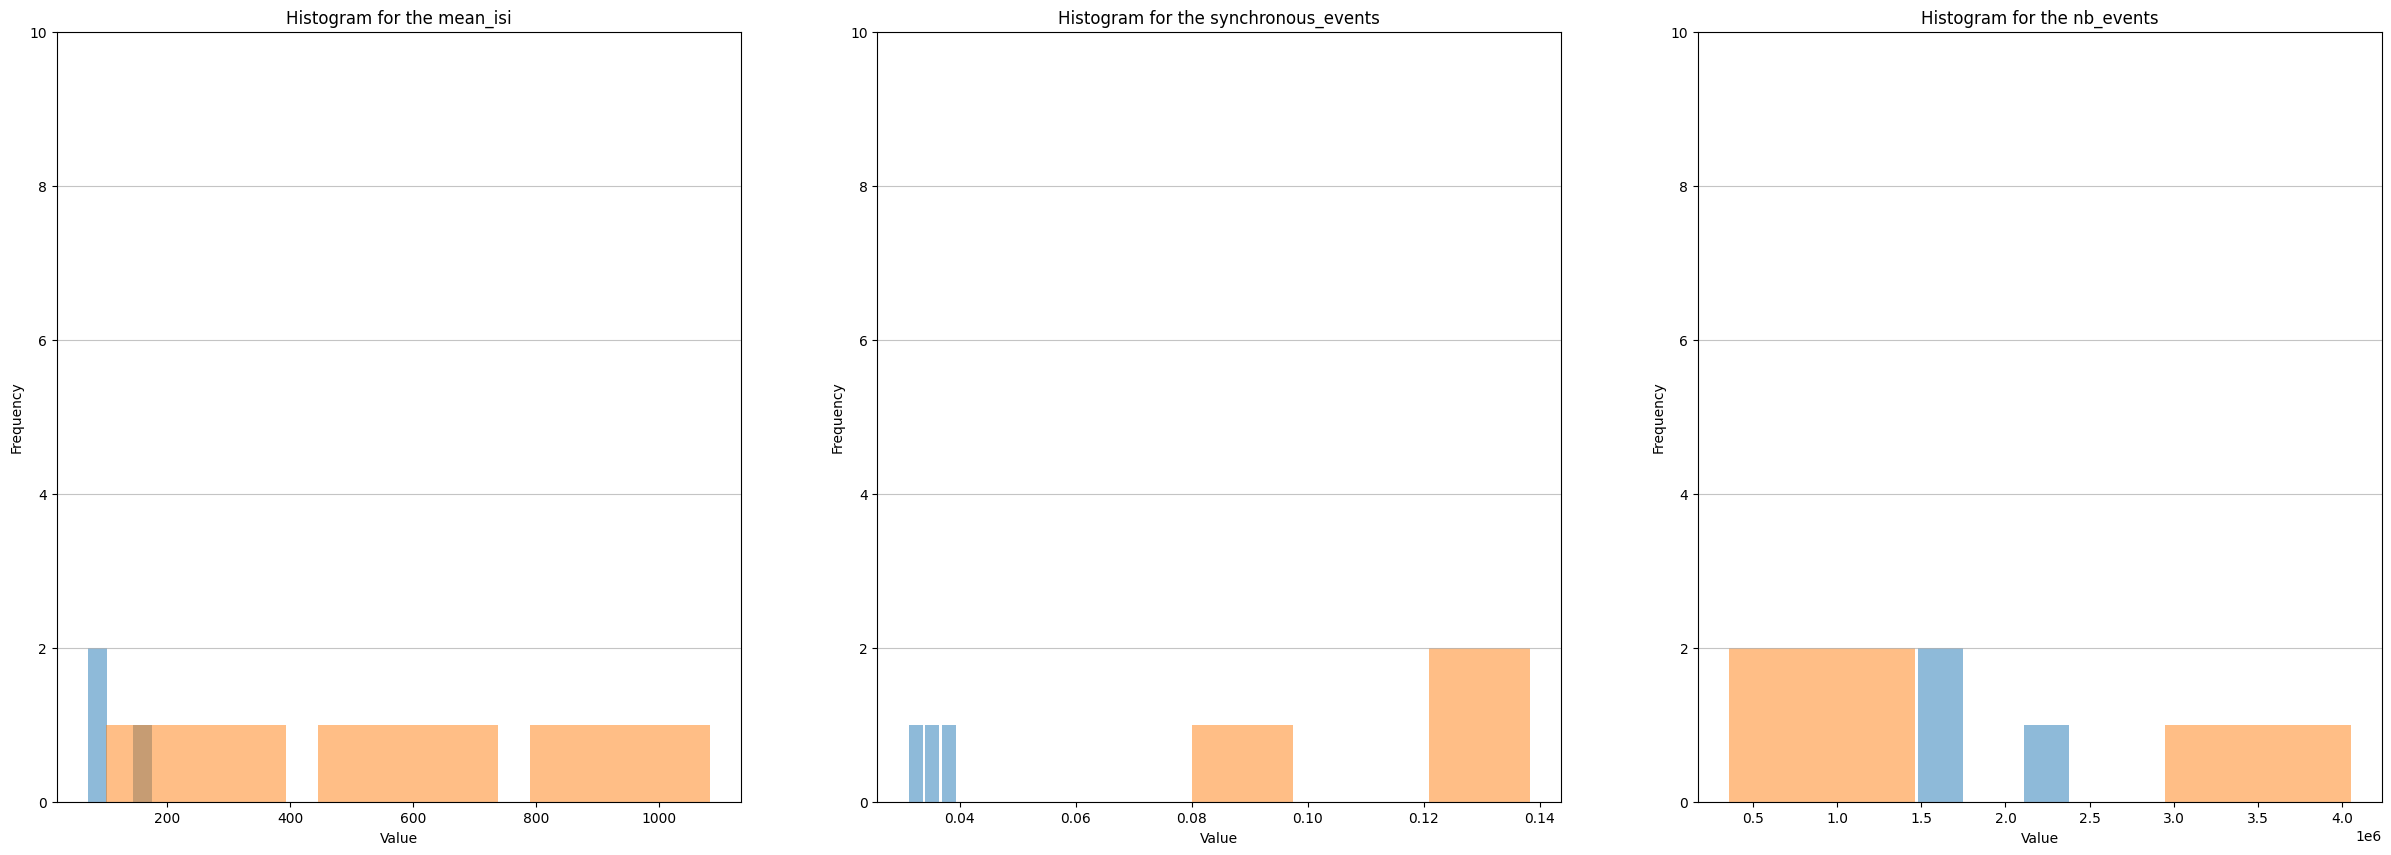

In [16]:
get_dataset_info(ev, distinguish_labels=True)